<a href="https://colab.research.google.com/github/bbutka/CEC595/blob/main/L09a_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will be:

- building a collage of images of plants that resembles an image of a pup
- optimize a noisy image so that the image is given a high classification score for a daisy by a VGG16 model
- introducing noise into an image of a goldfish so that the noise causes the image of the goldfish to be classified by a VGG16 model as a goldfinch bird.

Below we download our data, tiny ImageNet.

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

--2021-01-07 22:53:13--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip.2’

tiny-imagenet-200.z 100%[===================>] 236.61M  18.6MB/s    in 16s     

2021-01-07 22:53:29 (14.6 MB/s) - ‘tiny-imagenet-200.zip.2’ saved [248100043/248100043]

replace tiny-imagenet-200/words.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Next, we import the libraries we'll be using.

In [ ]:
#from PIL import Image
!pip install keras
!pip install tensorflow==1.14

from tensorflow.keras.preprocessing import image
import numpy as np
from sklearn.model_selection import train_test_split



Currently selected TF version: 2.x
Available versions:
* 1.x
* 2.x


Here, we load images from the categories we need, `pups` and `plants` as grayscale images.

In [ ]:
c = "n02099712"
pups = []
for i in range(500):
  img = image.load_img("tiny-imagenet-200/train/"+c+"/images/"+c+"_"+str(i)+".JPEG", color_mode="grayscale")
  img_arr = image.img_to_array(img)
  img_arr = img_arr.flatten()
  img_arr = img_arr.reshape(64,64,1)
  pups += [img_arr]
c = "n07715103" # cauliflower
#c = "n07734744" # mushroom
plants = []
if True:
  for i in range(500):
    img = image.load_img("tiny-imagenet-200/train/"+c+"/images/"+c+"_"+str(i)+".JPEG", color_mode="grayscale")
    img_arr = image.img_to_array(img)
    img_arr = img_arr.flatten()
    img_arr = img_arr.reshape(64,64,1)
    plants += [img_arr]

We define two functions:

- `sim` which calculates our similartity metric
- `mostsim` which finds the image most similar to the `target` image among the `sources` image 

In [ ]:
def sim(a,b):
#  print(a.shape, b.shape)
  return(-np.sum((a-b)**2))

def mostsim(sources, target):
  bestsim, bestsource = sim(sources[0], target), sources[0]
  for source in sources:
    simsource = sim(source, target)
    if simsource > bestsim: bestsim, bestsource = simsource, source
  return(bestsource)


This `make64` function scales up the `arr` image by `factor`

In [ ]:
def make64(arr,factor):
  out = np.empty((64,64,1))
  for x in range(out.shape[0]):
    for y in range(out.shape[1]):
      out[x,y] = arr[x//factor,y//factor]
  return(out)

Here's our target pup.

We use the functions we described above to build a large image out of our `plants` images that resembles the `pup` image.

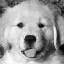

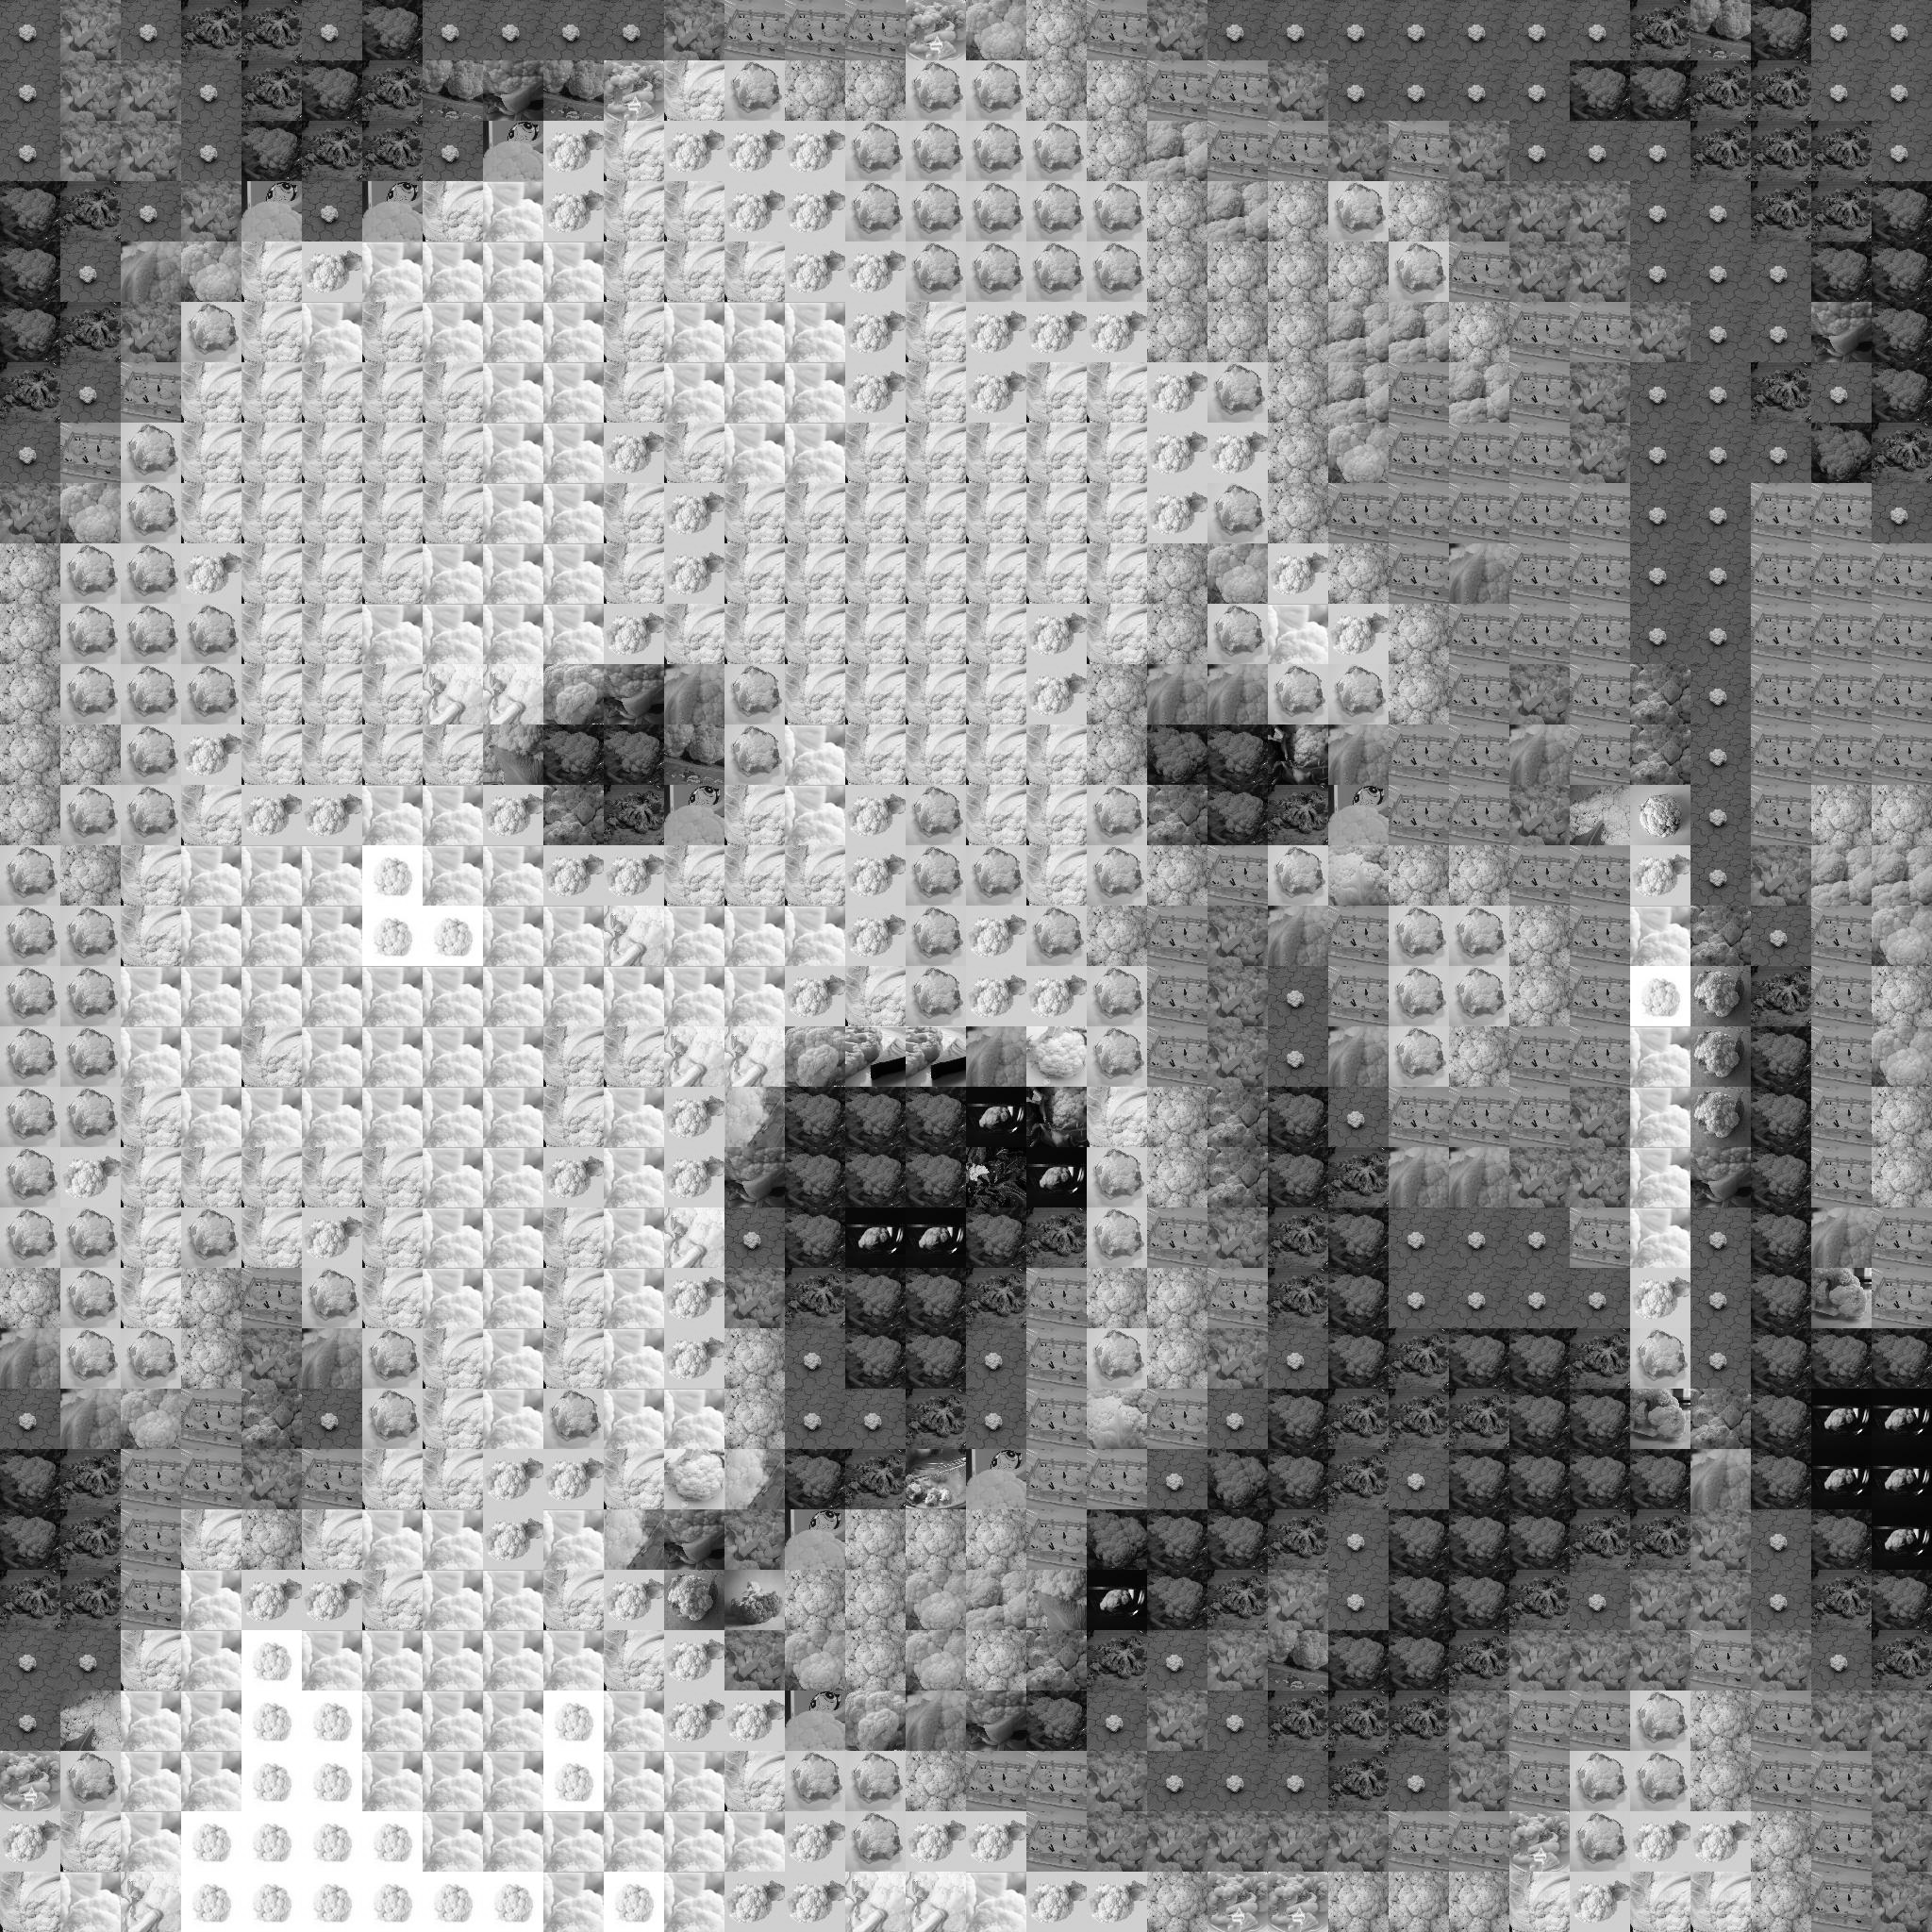

In [ ]:
pup = pups[4]



factor = 32
subsize = 64//factor
frankenpup = np.empty((64*factor,64*factor,1))
display(image.array_to_img(pup))
for x in range(factor):
  for y in range(factor):
    subpup = pup[(x*subsize):(x*subsize+subsize),(y*subsize):(y*subsize+subsize),]
    bigsubpup = make64(subpup,factor)
    plant = mostsim(plants,bigsubpup)
    frankenpup[(x*64):(x*64+64),(y*64):(y*64+64)] = plant #bigsubpup # mostsim(plants, bigsubpup)
pup
frankenpupimg = image.array_to_img(frankenpup)
frankenpupimg

Next we import additional libraries and get our VGG16 model which we will be using to make adversarial images that fools our VGG16 model.

In [7]:
import numpy as np
from tensorflow.keras.applications import vgg16
from tensorflow.keras import backend as K

 
# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet', include_top=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
553467904/553467096 [==============================] - 16s 0us/step


We import additional keras functions here.

In [8]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

In [9]:
model.input

<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>

In [10]:
input_tensor = tf.convert_to_tensor(model.input)

#input_var = tf.Variable(input_tensor)
with tf.GradientTape() as tape:
    tape.watch(input_tensor)

NameError: ignored

The `rand_image` function builds a random noise image.  We will display an example image, `img`, below.

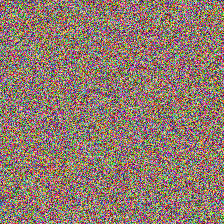

In [ ]:
def rand_image():
  img_arr = np.random.rand(1,224,224,3)*128+128
  img_arr = preprocess_input(img_arr)
  return(img_arr)
 
img = rand_image()
display(image.array_to_img(img[0]))

We print the top 10 predicted classes by our `model` for our example random image, `img`.

In [ ]:
preds = model.predict(img)
 
print('Predicted:', decode_predictions(preds, top=10)[0])


Predicted: [('n03291819', 'envelope', 0.114247814), ('n02840245', 'binder', 0.04280344), ('n02834397', 'bib', 0.042403422), ('n04525038', 'velvet', 0.03288497), ('n04548280', 'wall_clock', 0.028150802), ('n03485794', 'handkerchief', 0.024751099), ('n04476259', 'tray', 0.024165846), ('n04599235', 'wool', 0.014986888), ('n01930112', 'nematode', 0.014375843), ('n03347037', 'fire_screen', 0.014166463)]


Next we'll create a `daisy_score` which is the prediction given by  our VGG16 model for the daisy class.  We print out the `daisy_score` for our random image, `img`.

In [ ]:
def daisy_score(img):
  preds = model.predict(img)
  return(preds[0][208])
 
daisy_score(img)

0.000114388444

In this code block we: 
- generate 1000 random images
- get the `daisy_score` prediction for each random image
- store the `img` with the highest `daisy_scores` compared to all other proposed images as `bestimg` 
- print the highest `daisy_score`

In [ ]:
bestimg = None
maxdaisy = 0.0
for i in range(1000):
  img = rand_image()
  score = daisy_score(img)
  if (i%100)==0:
    print(i)
  if score > maxdaisy: maxdaisy, bestimg = score, img
daisy_score(bestimg)

0


KeyboardInterrupt: ignored

We `display` the image with the higest `daisy_score`, `bestimg`

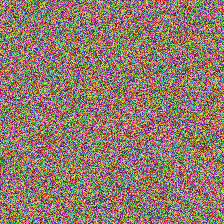

In [ ]:
display(image.array_to_img(bestimg[0]))

We collect the layer information of our `model` in `layer_dict` build an `objective` relative to the predictions for the daisy `target_class`, similar to our `daisy_score` function.  We will use this objective to generate an image that can lead the model to give the image a high prediction value for the daisy class.

In [ ]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
  
target_class = 985
 
input_tensor = model.input
x = layer_dict['predictions'].output[:, target_class]
objective = K.sum(x)

In [ ]:
objective

<tf.Tensor 'Sum:0' shape=() dtype=float32>

We calculate the gradient, `grads`, with respect to the `input_tensor` image and the daisy `objective`. We then define an `iterate` function in terms of the `input_tensor`, `objetive` and `grads`.

In [ ]:
grads = K.gradients(objective, input_tensor)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-12)
iterate = K.function([input_tensor], [objective, grads])

TypeError: ignored

In this code block, we will iteratively add to the random image, `img`, based on our daisy `objective` until is it greater then or equal to 0.9999999.

In [ ]:
obj_value = 0.0
while obj_value < 0.9999999: 
 obj_value, grads_value = iterate([img])
 print(obj_value)
 img += grads_value

NameError: ignored

Below is our image optimized for the daisy class.

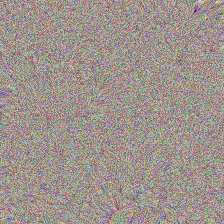

In [ ]:
display(image.array_to_img(img[0]))

In the following code blocks, we will be adding noise to a golsfish image so that VGG16 outputs a high prediction value for the goldfinch class. 

Below we load the VGG16 `model`.

In [ ]:
import numpy as np
from tensorflow.keras.applications import vgg16
from tensorflow.keras import backend as K
 
# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet', include_top=True)
print('Model loaded.')

Model loaded.


We download an image of a goldfish.

In [ ]:
# !wget http://c2.peakpx.com/wallpaper/137/72/865/veiltail-fish-goldfish-swim-aquarium-wallpaper-preview.jpg
!wget https://github.com/mlittmancs/great_courses_ml/raw/master/imgs/goldfish.jpg

--2021-01-07 23:18:46--  https://github.com/mlittmancs/great_courses_ml/raw/master/imgs/goldfish.jpg
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlittmancs/great_courses_ml/master/imgs/goldfish.jpg [following]
--2021-01-07 23:18:46--  https://raw.githubusercontent.com/mlittmancs/great_courses_ml/master/imgs/goldfish.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6577140 (6.3M) [application/octet-stream]
Saving to: ‘goldfish.jpg’

goldfish.jpg        100%[===================>]   6.27M  --.-KB/s    in 0.1s    

2021-01-07 23:18:47 (57.5 MB/s) - ‘goldfish.jpg’ saved [6577140/6577140]



We load and display the goldfish image, `img_arr`, below.

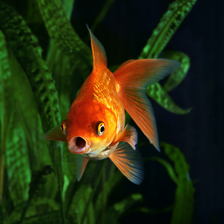

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

img = image.load_img("goldfish.jpg")
img = img.resize((224,224))
img_arr = image.img_to_array(img)
img_arr = img_arr.flatten()
img_arr = img_arr.reshape(1,224,224,3)
display(image.array_to_img(img_arr[0]))

Next we print the top 3 predicitions for this goldfish image by VGG16.

In [ ]:
preds = model.predict(img_arr)

print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n01443537', 'goldfish', 0.9766351), ('n09256479', 'coral_reef', 0.0065145832), ('n02655020', 'puffer', 0.005271918)]


In this code block we:

- collect the layer information for each layer in the `model` using `layer_dict`
- identify goldfinches as our `target_class` and define the predicitions for `target_class` as our `objective`
- calcuate the gradient, `grads` with respect to the `input_tensor` image and `obective`
- call the `iterate` function to add noise to the `input_img_data` image of the goldfish until the predtion for the goldfinch class is greater or equal to 0.8, printing the prediction for the image belonging to the goldfinch class each time we make an update
- `display` the new version of `input_img_data`

6.3758e-08
9.600663e-05
0.009492444
0.06413203
0.14895003
0.6796057
0.9331855


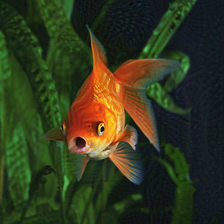

In [ ]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
  
target_class = 11 # 9 is ostrich, 1 is goldfish, 11 is goldfinch

learning_rate = 0.1

input_tensor = model.input
x = layer_dict['predictions'].output[:, target_class]
objective = K.sum(x)
grads = K.gradients(objective, input_tensor)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-12)
iterate = K.function([input_tensor], [objective, grads])
input_img_data = img_arr

loss_value = 0.0
while loss_value < 0.8: 
  loss_value, grads_value = iterate([input_img_data])
  print(loss_value)
  input_img_data += grads_value

display(image.array_to_img(input_img_data[0]))

We display the top 3 predictions for the new image.

In [ ]:
preds = model.predict(input_img_data)

print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n01531178', 'goldfinch', 0.98244286), ('n01537544', 'indigo_bunting', 0.0115030315), ('n01532829', 'house_finch', 0.0027921672)]


Now turn the goldfish into a Labrador Retriever

2.0745727e-08
0.00011778982
0.0040856036
0.034691114
0.21399125
0.5590348
0.8216994


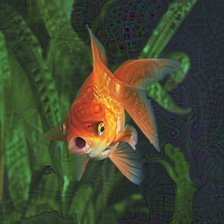

In [ ]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
  
target_class = 208 # 9 is ostrich, 1 is goldfish, 11 is goldfinch

learning_rate = 0.1

input_tensor = model.input
x = layer_dict['predictions'].output[:, target_class]
objective = K.sum(x)
grads = K.gradients(objective, input_tensor)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-12)
iterate = K.function([input_tensor], [objective, grads])
input_img_data = img_arr

loss_value = 0.0
while loss_value < 0.8: 
  loss_value, grads_value = iterate([input_img_data])
  print(loss_value)
  input_img_data += grads_value

display(image.array_to_img(input_img_data[0]))

In [ ]:
preds = model.predict(input_img_data)

print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02099712', 'Labrador_retriever', 0.8971775), ('n01704323', 'triceratops', 0.015253951), ('n09229709', 'bubble', 0.008383207)]


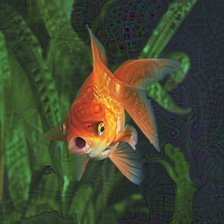

In [ ]:
delta=img_arr
display(image.array_to_img(delta[0]))